In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm 
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("../bayes_data/mt_ce_data.csv")
data = data[data["ce_car"] == 1]

<Axes: xlabel='age', ylabel='Count'>

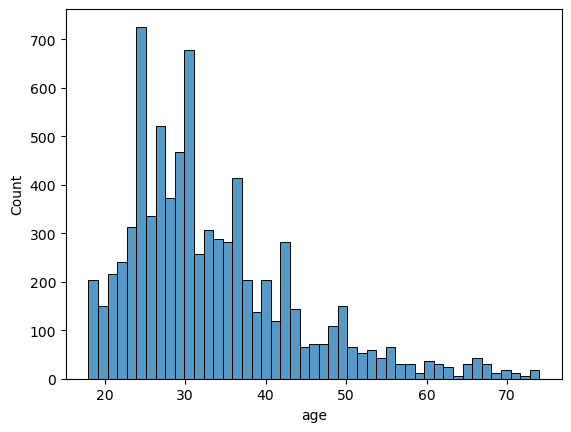

In [6]:
sns.histplot(data=data, x="age")

<Axes: xlabel='current_mode_cost', ylabel='Count'>

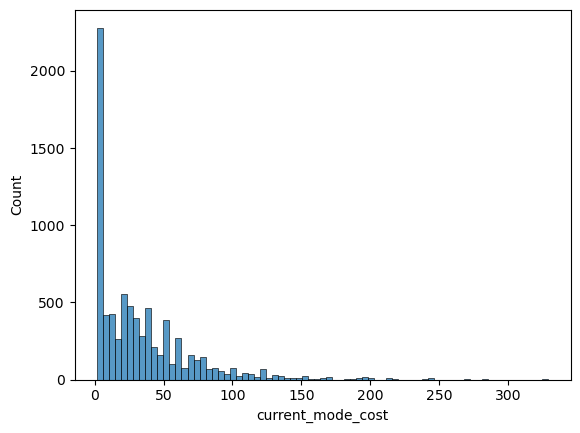

In [7]:
sns.histplot(data=data, x="current_mode_cost")

<Axes: xlabel='choice', ylabel='Count'>

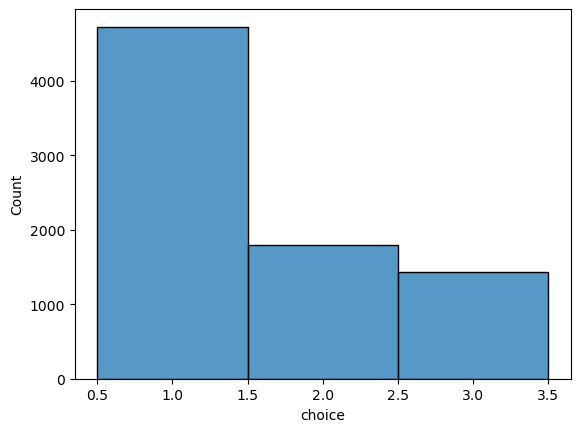

In [8]:
sns.histplot(data=data, x="choice", discrete=True)

In [3]:
Y = pd.Categorical(data.choice).codes
J = pd.Categorical(data.choice).categories
person_index, uniques = pd.factorize(data.userID)

coords = {
    "intercepts": ["sedan", "van"],
    "wait_times": ["sedan", "van"],
    "walk_times": ["sedan", "van"],
    "reserve_times": ["sedan", "van"],
    "passengers": ["sedan", "van"],
    "shelter": ["sedan", "van"],
    "probs": ["car", "sedan", "van"],
    "car_mt": ["car", "mt"],
    "observations": range(data.shape[0]),
    "indivs": uniques 
}

In [28]:
with pm.Model(coords=coords) as base_model:
    α = pm.Normal("alpha", mu=0, sigma=10, dims="intercepts")
    β_c = pm.Normal("b_cost", mu=0, sigma=5, dims="car_mt")
    β_t = pm.Normal("b_time", mu=0, sigma=5, dims="car_mt")
    β_age = pm.Normal("b_age", mu=0, sigma=5)

    u_car = β_c[0] * data.current_mode_cost + β_t[0] * data.current_mode_time
    u_sedan = α[0] + β_c[1] * data.sr_cost + β_t[1] * data.sr_tt + β_age * data.age
    u_van = α[1] + β_c[1] * data.sv_cost + β_t[1] * data.sv_tt + β_age * data.age
    
    s = pm.math.stack([u_car, u_sedan, u_van]).T
    p_ = pm.Deterministic("p_", pm.math.softmax(s, axis=1), dims=("observations", "probs"))

    y = pm.Categorical("y_obs", p=p_, observed=Y, dims="observations")

    inference_base = pm.sample(idata_kwargs={"log_likelihood": True})
    post_pred_base = pm.sample_posterior_predictive(inference_base)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b_cost, b_time, b_age]


ValueError: Not enough samples to build a trace.

In [11]:

with pm.Model(coords=coords) as corr_model:
    
    β_c = pm.Normal("b_cost", mu=0, sigma=5)
    β_t = pm.Normal("b_time", mu=0, sigma=5)
    β_age = pm.Normal("b_age", mu=0, sigma=5)


    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    
    α = pm.MvNormal("alpha", mu=0, chol=chol, dims="intercepts")

    u_car = β_c * data.current_mode_cost + β_t * data.current_mode_time
    u_sedan = α[0] + β_c * data.sr_cost + β_t * data.sr_tt + β_age * data.age
    u_van = α[1] + β_c * data.sv_cost + β_t * data.sv_tt + β_age * data.age
    
    s = pm.math.stack([u_car, u_sedan, u_van]).T
    p_ = pm.Deterministic("p_", pm.math.softmax(s, axis=1), dims=("observations", "probs"))

    y = pm.Categorical("y_obs", p=p_, observed=Y, dims="observations")

    inference_data_cm = pm.sample(idata_kwargs={"log_likelihood": True})
    post_pred_cm = pm.sample_posterior_predictive(inference_data_cm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_cost, b_time, b_age, chol, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


In [12]:
with pm.Model(coords=coords) as mixed_corr_model:
    # α = pm.Normal("alpha", mu=0, sigma=10, dims="intercepts")
    β_c = pm.Normal("b_cost", mu=0, sigma=5)
    β_t = pm.Normal("b_time", mu=0, sigma=5)
    β_age = pm.Normal("b_age", mu=0, sigma=5)
    β_indiv = pm.Normal("b_indiv", mu=0, sigma=1, dims=("indivs", "intercepts"))

    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    
    α = pm.MvNormal("alpha", mu=0, chol=chol, dims="intercepts")

    u_car = β_c * data.current_mode_cost + β_t * data.current_mode_time
    u_sedan = α[0] + β_indiv[person_index, 0] + β_c * data.sr_cost + β_t * data.sr_tt + β_age * data.age
    u_van = α[1] + β_indiv[person_index, 1] + β_c * data.sv_cost + β_t * data.sv_tt + β_age * data.age
    
    s = pm.math.stack([u_car, u_sedan, u_van]).T
    p_ = pm.Deterministic("p_", pm.math.softmax(s, axis=1), dims=("observations", "probs"))

    y = pm.Categorical("y_obs", p=p_, observed=Y, dims="observations")

    inference_data_mcm = pm.sample(idata_kwargs={"log_likelihood": True})
    post_pred_mcm = pm.sample_posterior_predictive(inference_data_mcm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_cost, b_time, b_age, b_indiv, chol, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


In [4]:
with pm.Model(coords=coords) as mixed_corr_model_specific_betas:

    β_c = pm.Normal("b_cost", mu=0, sigma=5, dims="car_mt")
    β_t = pm.Normal("b_time", mu=0, sigma=5, dims="car_mt")
    β_wt = pm.Normal("b_waittime", mu=0, sigma=5, dims="wait_times")
    β_walk = pm.Normal("b_walk", mu=0, sigma=5, dims="walk_times")
    β_pass = pm.Normal("b_pass", mu=0, sigma=5, dims="passengers")
    β_rt = pm.Normal("b_restime", mu=0, sigma=5, dims="reserve_times")
    β_shelter = pm.Normal("b_shelter", mu=0, sigma=5, dims="shelter")
    β_age = pm.Normal("b_age", mu=0, sigma=5)
    β_indiv = pm.Normal("b_indiv", mu=0, sigma=1, dims=("indivs", "intercepts"))

    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    
    α = pm.MvNormal("alpha", mu=0, chol=chol, dims="intercepts")

    u_car = β_c[0] * data.current_mode_cost + β_t[0] * data.current_mode_time

    u_sedan = (
        α[0] + 
        β_indiv[person_index, 0] + β_c[1] * data.sr_cost + β_t[1] * data.sr_tt + 
        β_wt[0] * data.sr_wait + β_walk[0] * data.sr_walk + β_rt[0] * data.sr_reserve + 
        β_shelter[0] * data.sr_desgpickup + β_pass[0] * data.sr_numshare + β_age * data.age
    )
    
    u_van = (
        α[0] + 
        β_indiv[person_index, 1] + β_c[1] * data.sv_cost + β_t[1] * data.sv_tt + 
        β_wt[1] * data.sv_wait + β_walk[1] * data.sv_walk + β_rt[1] * data.sv_reserve + 
        β_shelter[1] * data.sv_desgpickup + β_pass[1] * data.sv_numshare + β_age * data.age
    )
    
    s = pm.math.stack([u_car, u_sedan, u_van]).T
    p_ = pm.Deterministic("p_", pm.math.softmax(s, axis=1), dims=("observations", "probs"))

    y = pm.Categorical("y_obs", p=p_, observed=Y, dims="observations")

    inference_data_mcm_specific = pm.sample(idata_kwargs={"log_likelihood": True})
    post_pred_mcm_specific = pm.sample_posterior_predictive(inference_data_mcm_specific)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_cost, b_time, b_waittime, b_walk, b_pass, b_restime, b_shelter, b_age, b_indiv, chol, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 283 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


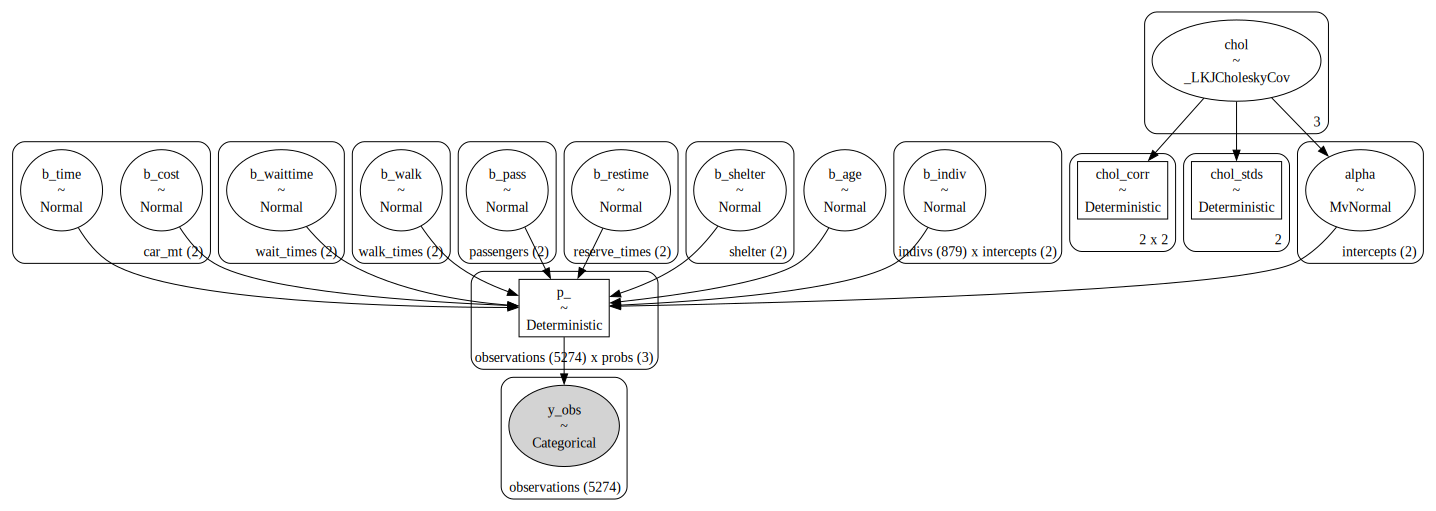

In [5]:
pm.model_to_graphviz(mixed_corr_model_specific_betas)

In [8]:
import arviz as az 
betas = ["b_cost", "b_time", "b_waittime", "b_walk", "b_shelter", "b_pass", "b_restime", "b_age"]

"""comp_df = az.compare({"base MNL": inference_base, 
                      "intercept correlation": inference_data_cm , 
                      "mixed logit w individual betas": inference_data_mcm, 
                      "mixed logit w individual and alternative specific betas": inference_data_mcm_specific})"""

'comp_df = az.compare({"base MNL": inference_base, \n                      "intercept correlation": inference_data_cm , \n                      "mixed logit w individual betas": inference_data_mcm, \n                      "mixed logit w individual and alternative specific betas": inference_data_mcm_specific})'

/Users/aesch/opt/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

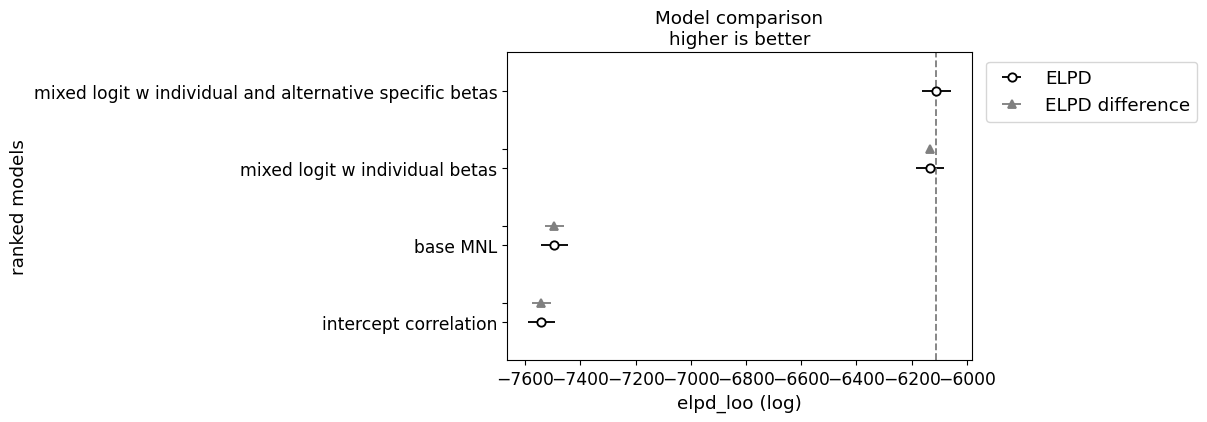

In [15]:
az.plot_compare(comp_df=comp_df)

In [32]:
az.summary(inference_data_mcm_specific, var_names=betas)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_cost[car],-0.011,0.004,-0.018,-0.003,0.000,0.000,2530.0,2587.0,1.00
b_cost[mt],-0.010,0.005,-0.019,-0.000,0.000,0.000,2353.0,2876.0,1.00
b_time[car],-0.054,0.007,-0.069,-0.041,0.000,0.000,2360.0,2610.0,1.00
b_time[mt],-0.039,0.006,-0.051,-0.027,0.000,0.000,2260.0,2733.0,1.00
b_waittime[sedan],-0.208,0.058,-0.322,-0.100,0.001,0.001,3490.0,2966.0,1.00
b_waittime[van],-0.239,0.066,-0.373,-0.125,0.002,0.001,1927.0,527.0,1.01
b_walk[sedan],-0.342,0.058,-0.457,-0.237,0.001,0.001,2589.0,2055.0,1.00
b_walk[van],-0.522,0.068,-0.656,-0.403,0.001,0.001,2969.0,3453.0,1.00
b_shelter[sedan],0.015,0.079,-0.134,0.157,0.001,0.001,3136.0,2668.0,1.00
b_shelter[van],0.064,0.112,-0.160,0.256,0.002,0.002,5364.0,3374.0,1.01


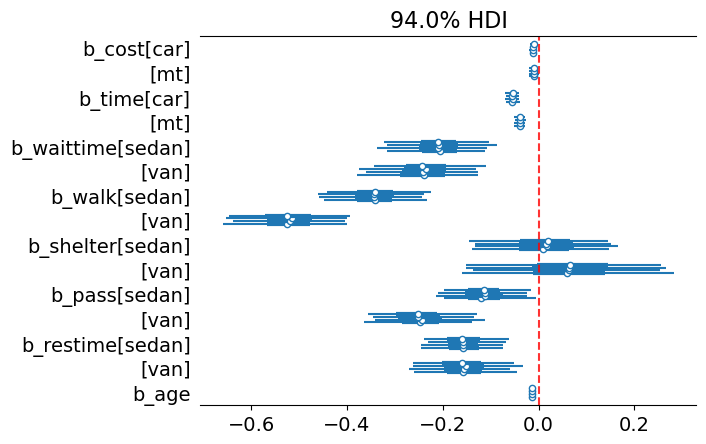

In [34]:
_, ax = plt.subplots(1)
az.plot_forest(data=inference_data_mcm_specific,
               var_names=betas,
               ax=ax)
ax.axvline(x=0, ls="--", color="red", alpha=0.8)

<Axes: xlabel='choice', ylabel='confidence'>

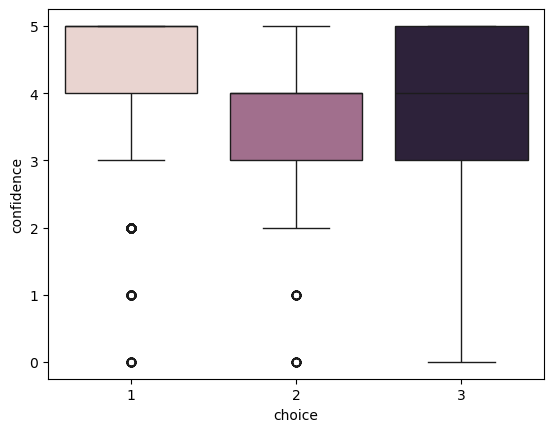

In [9]:
sns.boxplot(data=data, y="confidence", x="choice", hue="choice", legend=False)

In [12]:
data.filter(regex="wait")

,sr_wait,sv_wait,com_transit_waiting_time,transit_wait
0,0,0,0,0
1,0,1,0,0
2,1,0,0,0
3,2,1,0,0
4,2,2,0,0
...,...,...,...,...
7951,1,2,2,2
7952,0,1,2,2
7953,2,0,2,2
7954,0,0,2,2


In [15]:
data.filter(regex="sr_")

,sr_av,sr_tt_pivotmultiplier,sr_tc_pivotmultiplier,sr_tt,sr_tt_delta,sr_cost,sr_cost_delta,sr_numshare,sr_reserve,sr_wait,sr_walk,sr_desgpickup
0,1,0.7,0.90,31,-14,23,-3.0,0,2,0,2,1
1,1,1.0,0.80,45,0,21,-5.0,1,0,0,1,1
2,1,1.0,0.70,45,0,18,-8.0,2,0,1,2,0
3,1,0.7,0.90,31,-14,23,-3.0,0,0,2,0,1
4,1,1.0,0.80,45,0,21,-5.0,1,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7951,1,0.7,2.75,10,-4,10,6.5,1,0,1,1,0
7952,1,0.7,2.25,10,-4,8,4.5,0,2,0,1,1
7953,1,0.7,2.25,10,-4,8,4.5,2,0,2,0,0
7954,1,1.3,1.75,18,4,6,2.5,0,0,0,0,1


In [29]:
with pm.Model(coords=coords) as mixed_hier_model_specific_betas:

    # --------------------- ### DEFINE PRIORS ------------------------------------------------
    σ_ind = pm.HalfCauchy("sigma_ind", 20)

    chol_c, corr_c, stds_c = pm.LKJCholeskyCov(
        "chol_c", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    
    β_c = pm.MvNormal("b_cost_mt", mu=0, chol=chol_c, dims="wait_times")

    β_cc = pm.Normal("b_cost", mu=0, sigma=5)
    β_t = pm.Normal("b_time", mu=0, sigma=5, dims="car_mt")
    β_wt = pm.Normal("b_waittime", mu=0, sigma=5, dims="wait_times")
    β_walk = pm.Normal("b_walk", mu=0, sigma=5, dims="walk_times")
    β_pass = pm.Normal("b_pass", mu=0, sigma=5, dims="passengers")
    β_rt = pm.Normal("b_restime", mu=0, sigma=5, dims="reserve_times")
    β_shelter = pm.Normal("b_shelter", mu=0, sigma=5, dims="shelter")
    β_age = pm.Normal("b_age", mu=0, sigma=5)
    β_indiv = pm.Normal("b_indiv", mu=0, sigma=σ_ind, dims=("indivs", "intercepts"))
    
    α = pm.Normal("alpha", mu=0, sigma=1, dims="intercepts")


     # --------------------- ### UTILITY FUNCTIONS ### ---------------------------------------
    u_car = β_cc * data.current_mode_cost + β_t[0] * data.current_mode_time

    u_sedan = (
        α[0] + 
        β_indiv[person_index, 0] + β_c[0] * data.sr_cost + β_t[1] * data.sr_tt + 
        β_wt[0] * data.sr_wait + β_walk[0] * data.sr_walk + β_rt[0] * data.sr_reserve + 
        β_shelter[0] * data.sr_desgpickup + β_pass[0] * data.sr_numshare + β_age * data.age
    )
    
    u_van = (
        α[1] + 
        β_indiv[person_index, 1] + β_c[1] * data.sv_cost + β_t[1] * data.sv_tt + 
        β_wt[1] * data.sv_wait + β_walk[1] * data.sv_walk + β_rt[1] * data.sv_reserve + 
        β_shelter[1] * data.sv_desgpickup + β_pass[1] * data.sv_numshare + β_age * data.age
    )
    # ------------------------------------------------------------------------------------------

    s = pm.math.stack([u_car, u_sedan, u_van]).T
    p_ = pm.Deterministic("p_", pm.math.softmax(s, axis=1), dims=("observations", "probs"))

    # ------------------------ ### LOG-LIKELIHOOD ### -------------------------------------------
    y = pm.Categorical("y_obs", p=p_, observed=Y, dims="observations")

    inference_data_mixed_hier_specific = pm.sample(idata_kwargs={"log_likelihood": True})
    
    post_pred_mixed_hier_specific = pm.sample_posterior_predictive(inference_data_mixed_hier_specific)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_ind, chol_c, b_cost_mt, b_cost, b_time, b_waittime, b_walk, b_pass, b_restime, b_shelter, b_age, b_indiv, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 324 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


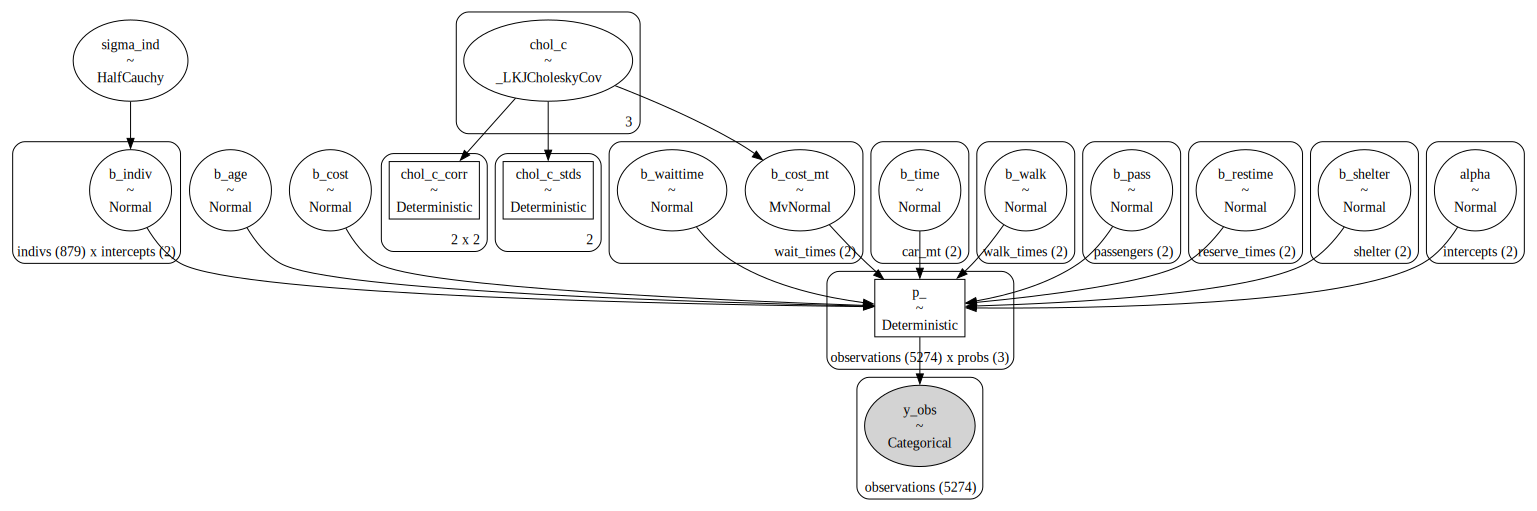

In [30]:
pm.model_to_graphviz(mixed_hier_model_specific_betas)

array([[<Axes: title={'center': 'b_cost'}>,
        <Axes: title={'center': 'b_cost'}>],
       [<Axes: title={'center': 'b_time'}>,
        <Axes: title={'center': 'b_time'}>],
       [<Axes: title={'center': 'b_cost_mt'}>,
        <Axes: title={'center': 'b_cost_mt'}>],
       [<Axes: title={'center': 'sigma_ind'}>,
        <Axes: title={'center': 'sigma_ind'}>]], dtype=object)

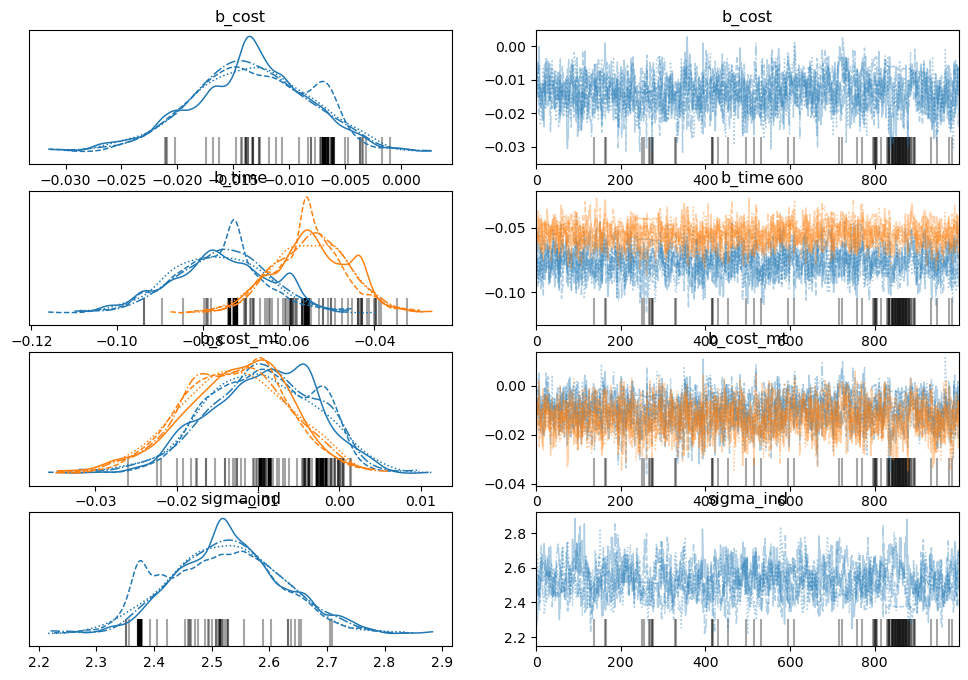

In [31]:
az.plot_trace(inference_data_mixed_hier_specific, var_names=["b_cost", "b_time", "b_cost_mt", "sigma_ind"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

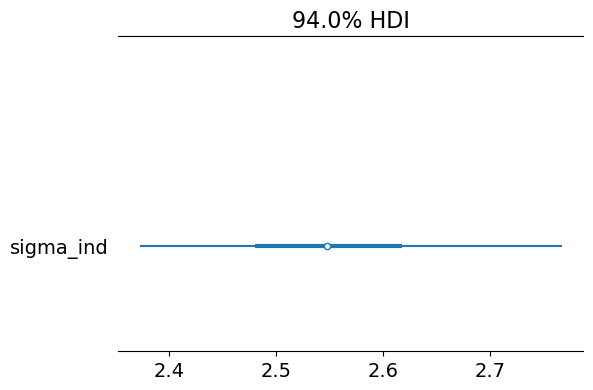

In [22]:
az.plot_forest(inference_data_mixed_hier_specific,
               combined=True,
               var_names=["sigma_ind"])